In [109]:
import cvxpy as cp
from cvxpy.atoms.affine.bmat import bmat
import numpy as np
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly

def make_signal(n_spikes, amplitude_noise): 
    spikes = (0.5 + np.arange(n_spikes)) / n_spikes
    phases = np.random.uniform(size=(n_spikes,))
    amplitudes = np.random.normal(size=(n_spikes,))
    return spikes, amplitudes * np.exp(2 * np.pi * 1j * phases)

def plot_signal(signal):
    spikes, vals = signal
    plt.plot(spikes, np.real(vals))
    plt.plot([0, 1], [0, 0], "r--")
    
def measure_signal(signal, cutoff):
    spikes, vals = signal 
    Fn = dft(signal, cutoff)
    return Fn @ vals

def dft(signal, cutoff):
    # compute the matrix F_n of corollary 1.4
    spikes, vals = signal
    freq_products = np.outer(np.arange(-cutoff, cutoff+1), spikes)
    Fn = np.exp(- 2 * np.pi * 1j * freq_products)
    return Fn

def evaluate_dual(X, fourier_coeffs):
    f_c = (fourier_coeffs.shape[0]-1)//2
    n = X.shape[0]
    
    freqs = np.arange(-f_c, f_c+1)
    evaluate_point = lambda x: np.dot(fourier_coeffs.flatten(), np.exp(2 * np.pi * 1j * freqs * x))
    return np.array([evaluate_point(x) for x in X]).reshape((-1, 1))


In [130]:
n_spikes = 5
f_c = 2*n_spikes
d = 2*f_c + 1

SIGNAL = make_signal(n_spikes, 1)
Y = measure_signal(SIGNAL, f_c)

In [131]:
Q = cp.Variable((d, d), hermitian=True) # is_hermitian makes Q complex automatically
c = cp.Variable((d, 1), complex=True)


constraints = [bmat([[Q, c], [c.H, np.eye(1)]]) >> 0] + \
    [cp.trace(np.eye(d, k=j).T @ Q) == (1 if j==0 else 0) for j in range(d)]

objective = cp.Maximize(cp.real(c.H @ Y))


In [132]:
prob = cp.Problem(objective, constraints)
prob.solve()

5.332588333873858

In [133]:
dual_coeffs = c.value[:, 0]
_dual_poly = np.poly1d(dual_coeffs) 
dual_poly = lambda t: _dual_poly(np.exp(2 * np.pi * 1j * t)) / np.exp(2 * np.pi * 1j * t * f_c)

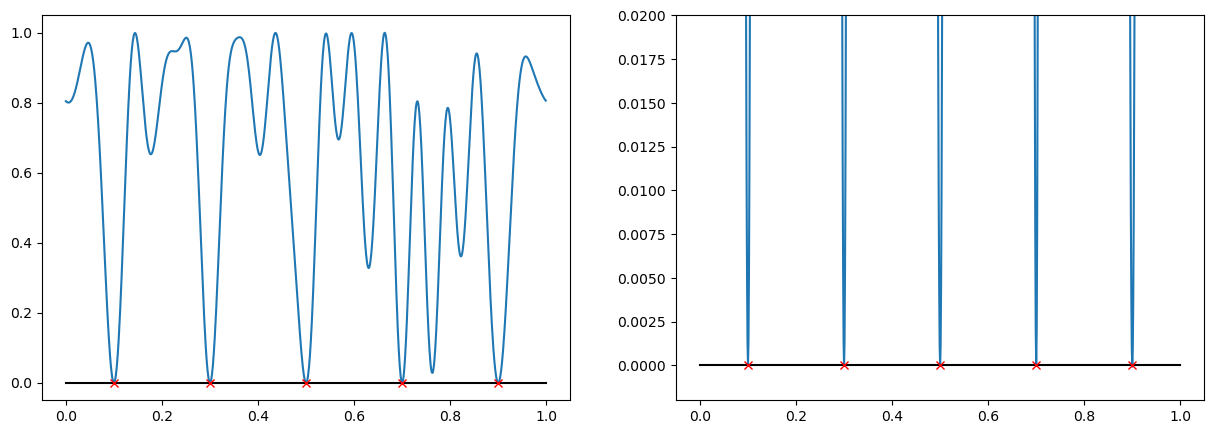

In [134]:
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, 1, 0.001), 1-np.abs(dual_poly(np.arange(0, 1, 0.001)))**2)
plt.plot([0, 1], [0, 0], "k-")
plt.plot(SIGNAL[0], n_spikes*[0], "rx")
plt.title("")

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, 1, 0.001), 1-np.abs(dual_poly(np.arange(0, 1, 0.001)))**2)
plt.plot([0, 1], [0, 0], "k-")
plt.plot(SIGNAL[0], n_spikes*[0], "rx")
plt.ylim(-0.002, 0.02)

plt.gcf().set_size_inches(15, 5)

